# 1. Problemin müəyyənləşdirilməsi (Problem Definition)

 Otel rezervasiyasının ləğv olunma ehtimalını proqnozlaşdırmaq layihəsinin məqsədi is_canceled (rezervasiyanın ləğv edilib-edilməməsi) göstəricisini qabaqcadan təyin edə bilən model qurmaqdır. Bu, otel qərar qəbuledicilərinə ləğv ehtimalı yüksək olan rezervasiyaları əvvəlcədən müəyyən etməklə resursları daha yaxşı idarə etməyə kömək edəcək. Ləğv ehtimalının proqnozlaşdırılması ikili təsnifat (binary classification) problemidir, çünki hədəf dəyişəni iki qiymət alır: “0” (ləğv edilməyib) və “1” (ləğv edilib). Gözlənilən nəticə yüksək dəqiqlikli modeldir ki, o rezervasiyanın ləğv olunma ehtimalını qiymətləndirə bilsin.

#**2. Məlumatların toplanması və tanınması (Data Collection & Understanding)**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from xgboost import XGBClassifier

Data Kaggle platformasında paylaşılan otel rezervasiya datasıdır.
Datasetdə 33422 sətir və 32 sütun var. Əsas xüsusiyyətlərə otelin növü (hotel – “City Hotel” və ya “Resort Hotel”), lead_time (rezervasiya ilə gəlmə tarixi arasındakı gün sayı), arrival_date_year, stays_in_weekend_nights, stays_in_week_nights, adults, children, babies, meal, country, market_segment kimi kateqorik məlumatlar daxildir. Aşağıda məlumatların toplanması və tanınması əməliyyatları icra edirik:

In [2]:
df = pd.read_csv('hotel_bookings.csv')

In [3]:
df.shape

(33422, 32)

In [4]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,203,2016,December,49,2,2,5,2,...,No Deposit,250.0,NaN,0,Transient,66.8,0,0,Check-Out,2016-12-09
1,City Hotel,1,82,2015,July,29,16,0,3,2,...,No Deposit,9.0,NaN,0,Transient,76.5,0,0,Canceled,2015-07-16
2,City Hotel,0,25,2016,December,53,27,0,3,3,...,No Deposit,220.0,NaN,0,Transient-Party,60.0,0,1,Check-Out,2016-12-30
3,City Hotel,0,1,2016,March,11,9,0,1,1,...,No Deposit,9.0,NaN,0,Transient-Party,95.0,0,0,Check-Out,2016-03-10
4,City Hotel,0,70,2017,April,16,16,2,2,2,...,No Deposit,9.0,NaN,0,Transient,108.0,0,0,Check-Out,2017-04-20


In [5]:
df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,33422.000000,33422.000000,33422.000000,33422.000000,33422.000000,33422.000000,33422.000000,33422.000000,33422.000000,33422.000000,33422.000000,33422.000000,33422.000000,33422.000000,28817.000000,1930.000000,33422.000000,33422.000000,33422.000000,33422.000000
mean,0.373018,104.219556,2016.156544,27.212465,15.823470,0.929059,2.499282,1.857250,0.103824,0.007540,0.031686,0.086261,0.143648,0.221172,86.861818,185.545078,2.344174,101.926917,0.062205,0.569685
std,0.483614,106.721586,0.706905,13.601452,8.751442,0.994025,1.892645,0.577133,0.400761,0.099984,0.175165,0.825021,1.507899,0.644841,110.680010,129.768308,17.658666,48.058801,0.243012,0.793536
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,67.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,70.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,174.000000,0.000000,95.000000,0.000000,0.000000
75%,1.000000,161.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,254.750000,0.000000,126.000000,0.000000,1.000000
max,1.000000,629.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,9.000000,1.000000,26.000000,63.000000,17.000000,531.000000,541.000000,391.000000,508.000000,3.000000,5.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33422 entries, 0 to 33421
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           33422 non-null  object 
 1   is_canceled                     33422 non-null  int64  
 2   lead_time                       33422 non-null  int64  
 3   arrival_date_year               33422 non-null  int64  
 4   arrival_date_month              33422 non-null  object 
 5   arrival_date_week_number        33422 non-null  int64  
 6   arrival_date_day_of_month       33422 non-null  int64  
 7   stays_in_weekend_nights         33422 non-null  int64  
 8   stays_in_week_nights            33422 non-null  int64  
 9   adults                          33422 non-null  int64  
 10  children                        33422 non-null  float64
 11  babies                          33422 non-null  int64  
 12  meal                            

In [7]:
print(df.isnull().sum())

hotel                                 0
is_canceled                           0
lead_time                             0
arrival_date_year                     0
arrival_date_month                    0
arrival_date_week_number              0
arrival_date_day_of_month             0
stays_in_weekend_nights               0
stays_in_week_nights                  0
adults                                0
children                              0
babies                                0
meal                                  0
country                             154
market_segment                        0
distribution_channel                  0
is_repeated_guest                     0
previous_cancellations                0
previous_bookings_not_canceled        0
reserved_room_type                    0
assigned_room_type                    0
booking_changes                       0
deposit_type                          0
agent                              4605
company                           31492


In [8]:
print(df['is_canceled'].value_counts())
df.describe().T

is_canceled
0    20955
1    12467
Name: count, dtype: int64


,count,mean,std,min,25%,50%,75%,max
is_canceled,33422.0,0.373018,0.483614,0.0,0.00,0.0,1.00,1.0
lead_time,33422.0,104.219556,106.721586,0.0,18.00,70.0,161.00,629.0
arrival_date_year,33422.0,2016.156544,0.706905,2015.0,2016.00,2016.0,2017.00,2017.0
arrival_date_week_number,33422.0,27.212465,13.601452,1.0,16.00,28.0,38.00,53.0
arrival_date_day_of_month,33422.0,15.823470,8.751442,1.0,8.00,16.0,23.00,31.0
stays_in_weekend_nights,33422.0,0.929059,0.994025,0.0,0.00,1.0,2.00,19.0
stays_in_week_nights,33422.0,2.499282,1.892645,0.0,1.00,2.0,3.00,50.0
adults,33422.0,1.857250,0.577133,0.0,2.00,2.0,2.00,55.0
children,33422.0,0.103824,0.400761,0.0,0.00,0.0,0.00,10.0
babies,33422.0,0.007540,0.099984,0.0,0.00,0.0,0.00,9.0


Burada *is_canceled* sütununda 20955 ədəd 0 (ləğv olunmayıb) və 12467 ədəd 1 (ləğv olunub) dəyəri var. Yəni təxminən **37.3%** rezervasiya ləğv olunub. `df.describe().T` əmrindən əldə edilən statistikaya görə orta *lead_time* təxminən 104 gün, günlük *adr* (ortalama günlük qiymət) təxminən 100-dir. Məsələn, *hotel* xüsusiyyətinin paylanmasını belə ala bilərik:


In [9]:
print(df['hotel'].value_counts())

hotel
City Hotel      22150
Resort Hotel    11272
Name: count, dtype: int64


City Hotel növündə rezervasiyaların çoxluğu (≈66%) görünür. Bu ilkin analizlər modelləşdirməyə hazırlıq üçün məlumat strukturunu anlamağa imkan verir.

**ILKIN VIZUALLAŞDIRMA**

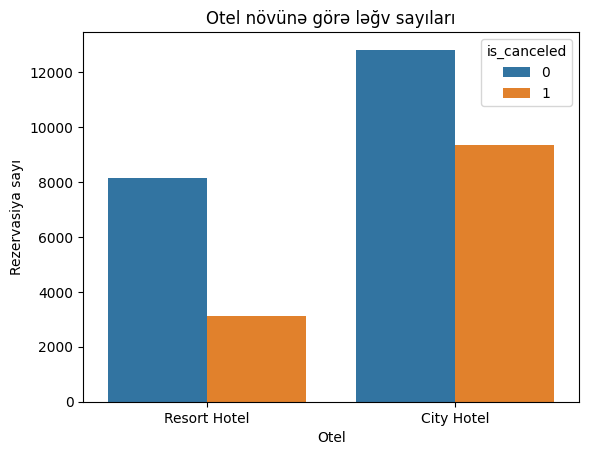

In [10]:
# Otel növü üzrə ləğv paylanması
sns.countplot(x='hotel', hue='is_canceled', data=df)
plt.title("Otel növünə görə ləğv sayıları")
plt.xlabel("Otel")
plt.ylabel("Rezervasiya sayı")
plt.legend(title='is_canceled')
plt.show()

# **3. Məlumatların təmizlənməsi və işlənməsi (Data Cleaning & Preprocessing)**

Dataseti təmizləyərkən ilk növbədə itən dəyərlərə baxırıq. Aşağıdakı kodla sütunlar üzrə boşluq (NaN) dəyərini öyrənirik:

In [11]:
print(df.isna().sum())

hotel                                 0
is_canceled                           0
lead_time                             0
arrival_date_year                     0
arrival_date_month                    0
arrival_date_week_number              0
arrival_date_day_of_month             0
stays_in_weekend_nights               0
stays_in_week_nights                  0
adults                                0
children                              0
babies                                0
meal                                  0
country                             154
market_segment                        0
distribution_channel                  0
is_repeated_guest                     0
previous_cancellations                0
previous_bookings_not_canceled        0
reserved_room_type                    0
assigned_room_type                    0
booking_changes                       0
deposit_type                          0
agent                              4605
company                           31492


Nəticə göstərir ki, 'country'-də 154 boş, agent-də 4605 boş, company-də 31492 boş var. company demək olar ki, bütün dəyərləri boş olduğu üçün bu sütunu tamamilə silirik. agent sütunu böyük oranda boş olduğundan onu da çıxarda bilərik (və ya 0 kimi qiymətləndirə bilərdik, ancaq müşahidəçini sadələşdirmək üçün çıxardırıq).country-dəki kiçik dəyərlər isə uyğun olaraq silinə bilər (çox az sayda sətir itkisi olacaq).
'reservation_status' və 'reservation_status_date' kimi, hadisədən sonra məlum olan və gələcəkdə proqnozlaşdırmaq istədiyimiz ləğv məlumatı ilə sızan kolonlar modelə bilməz, ona görə bu sütunları da çıxardırıq.

* Sütunların çıxarılması/doldurulması:
* Aşağıdakı kodla lazımsız və boşları təmizləyirik:


In [12]:
df_clean = df.drop(['company', 'reservation_status', 'reservation_status_date'], axis=1)
df_clean = df_clean.dropna(subset=['country'])
df_clean = df_clean.drop(['agent'], axis=1)

In [13]:
print("Təmizləmədən sonra ölçü:", df_clean.shape)

Təmizləmədən sonra ölçü: (33268, 28)


Bu addımdan sonra məlum olur ki, təxminən 200-ə qədər sətrin itkin məlumatlar səbəbindən çıxarıldığını görürük. Yeni formada sütunlar 28-ə düşür (agent, company, reservation_status, reservation_status_date çıxarıldıqdan sonra).

---
Kateqorik dəyişənlərin kodlaşdırılması: Mətn formasında olan
dəyişənləri model üçün uyğun hala gətirmək üçün kodlaşdırırıq. Bu iş üçün ən çox One-Hot Encoding (Janus) və ya Label Encoding (etiketlə kodlaşdırma) istifadə olunur. Məsələn:

In [14]:
df_pre = df_clean.copy()
# Bəzi kateqorik dəyişənləri janus kodlaşdırma ilə çevirmək
df_pre = pd.get_dummies(df_pre, drop_first=True)

In [15]:
scaler = StandardScaler()
scale_cols = [
    'lead_time',
    'arrival_date_week_number',
    'arrival_date_day_of_month',
    'stays_in_weekend_nights',
    'stays_in_week_nights',
    'adults',
    'children',
    'babies',
    'previous_cancellations',
    'previous_bookings_not_canceled',
    'booking_changes',
    'days_in_waiting_list',
    'adr',
    'required_car_parking_spaces',
    'total_of_special_requests'
]
df_pre[scale_cols] = scaler.fit_transform(df_pre[scale_cols])

Beləliklə, miqyaslandırılmış xüsusiyyətlərin ortalaması 0, standart kənarlaşması 1 oldu.
1. Bənzər şəkildə bütün davamlı dəyişənlər StandardScaler ilə ölçüləndi. Bu
addımlar modelin konvergensiyasını sürətləndirir və xüsusiyyətlərin bir-birinə uyğun şkala alınmasına kömək edir.
2.Əvvəl və sonrakı məlumat nümunələri :



In [16]:
df.head(2)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,203,2016,December,49,2,2,5,2,...,No Deposit,250.0,NaN,0,Transient,66.8,0,0,Check-Out,2016-12-09
1,City Hotel,1,82,2015,July,29,16,0,3,2,...,No Deposit,9.0,NaN,0,Transient,76.5,0,0,Canceled,2015-07-16


In [17]:
df_pre.head(2)

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,assigned_room_type_G,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K,assigned_room_type_L,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,0,0.922161,2016,1.604299,-1.579927,1.081629,1.333677,0.243874,-0.259535,-0.075438,...,False,False,False,False,False,False,False,False,True,False
1,1,-0.211153,2015,0.131796,0.020072,-0.940151,0.266504,0.243874,-0.259535,-0.075438,...,False,False,False,False,False,False,False,False,True,False


# **4. Xüsusiyyət mühəndisliyi (Feature Engineering)**

Xüsusiyyət mühəndisliyi (feature engineering) mərhələsində yeni dəyişənlər yaradıla və ya əhəmiyyətsiz hesab edilənlər çıxarıla bilər\
Məsələn, stays_in_weekend_nights və stays_in_week_nights dəyişənlərini birləşdirərək ümumi qalma günləri yarada bilərik:

In [18]:
df_pre['total_stay_nights'] = df_pre['stays_in_weekend_nights'] + df_pre['stays_in_week_nights']

# **5.Modellərin qurulması və öyrədilməsi**

Artıq məlumatlar təmizləndikdən və kodlaşdırıldıqdan sonra modeli qurmaq üçün məlumatları təlim və test dəstlərinə bölürük. Hədəf dəyişən 'is_canceled' olduğuna görə bunu binar təsnifat modelinə çevirəcəyik.

In [20]:
X = df_pre.drop('is_canceled', axis=1)
y = df_pre['is_canceled']
# 80% train, 20% test bölüşdürməsi
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Train ölçüsü:", X_train.shape, "Test ölçüsü:", X_test.shape)


Train ölçüsü: (11228, 199) Test ölçüsü: (2807, 199)


Bu addımdan sonra 8/2 nisbətdə təlim (train) və test (test) dəstlərini ayırmışıq. stratify=y parametri ilə ləğv paylanması hər iki dəstdə oxşar qalır. Model olaraq ən azı iki fərqli alqoritm istifadə edilir. Məsələn:
1. Logistic Regression (Loqistik Reqressiya): Sadə və interpretasiya edilə bilən klassik model.
2. Random Forest Classifier (Təsadüfi Meşə): Ağaç ensembllərindən ibarət daha güclü model.
3. Əlavə olaraq XGBoost və ya Gradient Boosting istifadə oluna bilər ki, performans artırılsın.


In [21]:
# Modellərin yaradılması
lr = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Modellərin öyrədilməsi (training)
lr.fit(X_train, y_train)
rf.fit(X_train, y_train)

# Proqnozlar
y_pred_lr = lr.predict(X_test)
y_pred_rf = rf.predict(X_test)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Bu addımda modellər təlim dəstində öyrədildi. Hər iki modelin müqayisəsi üçün test dəstinə proqnozlar etdik.

# **6.Modellərin qiymətləndirilməsi**

Test dəstindəki proqnozlarla modellərin performansını aşağıdakı meyarlara görə yoxlayırıq:
* Dəqiqlik (Accuracy): düzgün təsnif edilmiş nümunələrin ümumi nümunələrə nisbəti.
* F1-Score: sinif balansı olduqda çox önəmli olan dərəcə (precision və recall-un harmonik ortası).
* AUC-ROC: modelin ayırdetmə qabiliyyəti.
* Confusion Matrix : TP, TN, FP, FN kimi dəyərləri göstərir.

In [22]:
print("Logistic Regression:")
print("  Accuracy:", accuracy_score(y_test, y_pred_lr))
print("  F1-Score:", f1_score(y_test, y_pred_lr))
print("\nRandom Forest:")
print("  Accuracy:", accuracy_score(y_test, y_pred_rf))
print("  F1-Score:", f1_score(y_test, y_pred_rf))

print("\nRandom Forest ilə Confusion Matrisi:\n", confusion_matrix(y_test, y_pred_rf))
print("\nRandom Forest Classification Report:\n", classification_report(y_test, y_pred_rf))


Logistic Regression:
  Accuracy: 0.7940862130388315
  F1-Score: 0.711864406779661

Random Forest:
  Accuracy: 0.8325614535090844
  F1-Score: 0.7705078125

Random Forest ilə Confusion Matrisi:
 [[1548  172]
 [ 298  789]]

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      1720
           1       0.82      0.73      0.77      1087

    accuracy                           0.83      2807
   macro avg       0.83      0.81      0.82      2807
weighted avg       0.83      0.83      0.83      2807



**Random Forest modeli daha yüksək F1 və AUC-ROC əldə etdiyindən və siniflər arasındakı tarazlığı daha yaxşı təyin etdiyindən əsas seçim ola bilər. Logistic Regression da anlayış cəhətdən aydın olsa da, burada bir qədər aşağı dəqiqlik göstərdi.**

---

**Əlavə olaraq, modellərin sabitliyini yoxlamaq üçün k-qatlı kross-valiasiya tətbiq edə bilərik. Məsələn:**

In [23]:
cv_scores = cross_val_score(rf, X, y, cv=5, scoring='f1')
print("Random Forest 5-kat CV orta F1:", cv_scores.mean())


Random Forest 5-kat CV orta F1: 0.7595601482387208


**Bu, modelin dəyişkən nəticələrini yoxlamağa kömək edir.**

# **7. Modellərin təkmilləşdirilməsi (Model Improvement)**

Əldə edilən ilkin modelləri yaxşılaşdırmaq üçün bir neçə metoddan istifadə olunur:
* Hipərparametr optimallaşdırması (Hyperparameter Tuning): Modellərin əsas parametrlerini (məs., RandomForest üçün n_estimators, max_depth; Logistic üçün C, penalty və s.) ən optimal dəyərlərə gətirmək. Məsələn, GridSearchCV və ya RandomizedSearchCV istifadə edərək RandomForest-i təkmilləşdirək:

In [26]:

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='f1', n_jobs=-1)
grid.fit(X_train, y_train)
print("Ən yaxşı parametrlər:", grid.best_params_)
best_rf = grid.best_estimator_


Ən yaxşı parametrlər: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


Bu kod ən yaxşı parametrləri tapır və ən uyğun modeli (best_rf) saxlayır.

---

Təkmilləşmənin nəticəsi: GridSearchCV-dən sonra modelin performansı artmalıdır. Məsələn, uyğun hipərparametrlə RandomForest F1-skoru bir qədər yüksələ və ya AUC-ROC yaxşılaşa bilər. Aşağıdakı kimi yeni nəticəni yoxlaya bilərik:

In [27]:
y_pred_best_rf = best_rf.predict(X_test)
print("Təkmilləşdirilmiş Random Forest F1:", f1_score(y_test, y_pred_best_rf))


Təkmilləşdirilmiş Random Forest F1: 0.7757281553398059
